# AR and 2ndMoA of wings of each family

In [163]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [167]:
basedir = './real_samples/atap_20plus_reconstructions512d/fw'
# basedir = './real_samples/atap_20plus_reconstructions40d/fw'
# basedir = './real_samples/atap_20plus/fw'

In [168]:
png_files = [f for f in os.listdir(basedir) if f.lower().endswith('.png')]

In [169]:
png_files.sort()

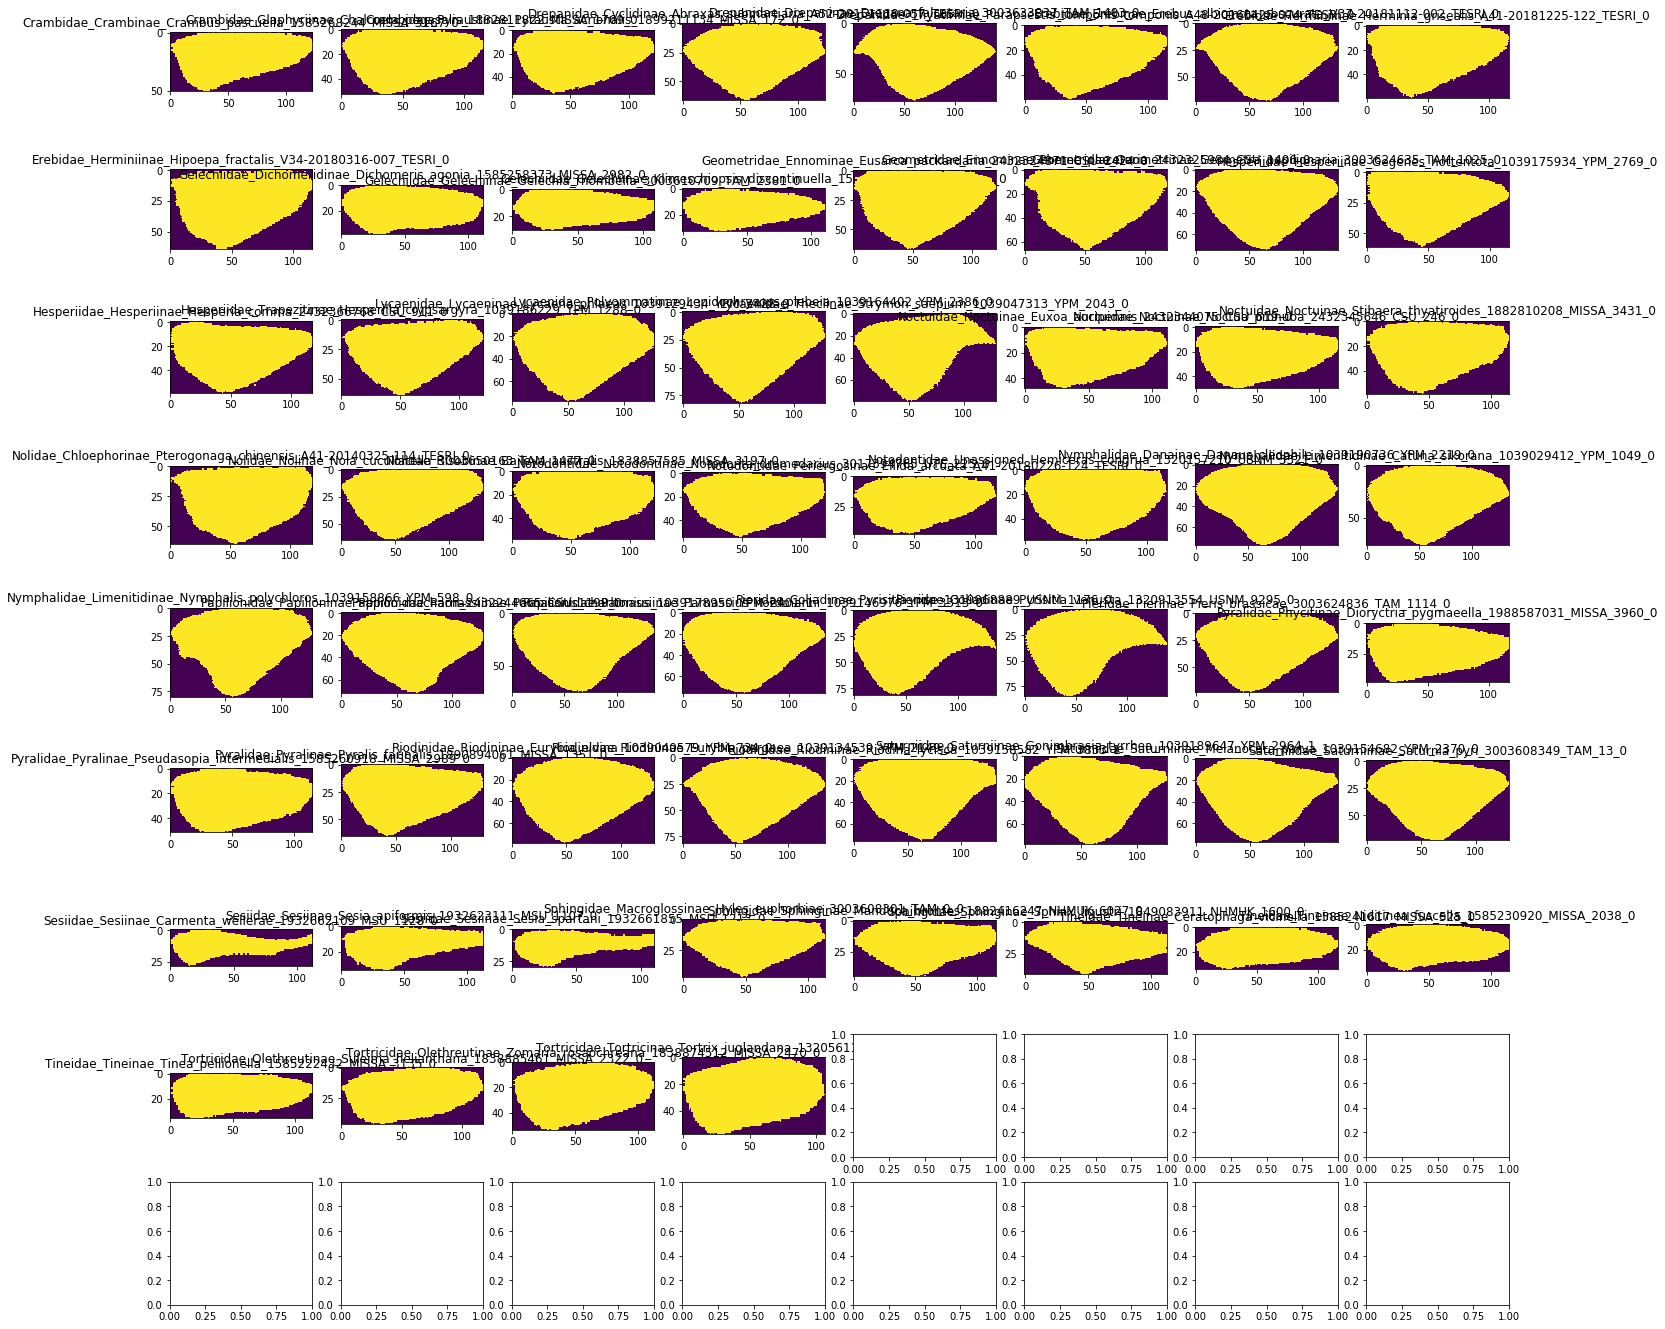

In [170]:
plt.rcParams['figure.figsize'] = [24, 24]
fig, axes = plt.subplots(9, 8)
aspect_ratios = []
nd_second_moment_of_areas_root_on_left = []
nd_second_moment_of_areas_root_on_right = []


fams_hflip = ['Endromidae.png', 'Eupterotidae.png', 'Mimallonidae.png']

for i in range(len(png_files)):
    
#    hflip = False
    
    im = cv2.imread(f'{basedir}/{png_files[i]}', -1)

    im_binary = np.zeros(im.shape[:2], dtype=np.uint8)
    #bg_idx = np.where((im[..., 0] == 255)&(im[..., 1] == 255)&(im[..., 2] == 255))
    bg_idx = np.where(im[..., 3] == 0)

#     if (bg_idx[1] < 128).sum() > (bg_idx[1] >= 128).sum():
#         hflip = False
#     elif (bg_idx[1] < 128).sum() < (bg_idx[1] >= 128).sum():
#         hflip = True
#     else:
#         raise Exception("The left background should not be equal to the right background?")
    
    im_binary[bg_idx] = 255

    im_binary_idx = np.array(np.where(im_binary == 0)).T

    pca = PCA()

    im_pca_idx = pca.fit_transform(im_binary_idx)

    span_y = int(np.round(im_pca_idx[:,0].max())) - int(np.round(im_pca_idx[:,0].min())) + 1
    span_x = int(np.round(im_pca_idx[:,1].max())) - int(np.round(im_pca_idx[:,1].min())) + 1
    im_pca_binary = np.zeros((span_y, span_x), dtype=np.uint8)

    im_pca_binary_y_idx = np.round(im_pca_idx[:,0]).astype(int) - int(np.round(im_pca_idx[:,0].min()))
    im_pca_binary_x_idx = np.round(im_pca_idx[:,1]).astype(int) - int(np.round(im_pca_idx[:,1].min()))

    kernel = (1,1)
    im_pca_binary[im_pca_binary_y_idx, im_pca_binary_x_idx] = 255
    im_pca_binary = cv2.erode(cv2.dilate(im_pca_binary, kernel, iterations=1), kernel, iterations=1)

    # rotation
    max_y_at_y_idx = max(im_pca_binary_y_idx)
    min_y_at_y_idx = min(im_pca_binary_y_idx)
    max_y_at_x_idx = np.median(im_pca_binary_x_idx[np.where(im_pca_binary_y_idx == max_y_at_y_idx)[0]]).astype(int)
    min_y_at_x_idx = np.median(im_pca_binary_x_idx[np.where(im_pca_binary_y_idx == min_y_at_y_idx)[0]]).astype(int)    
    
    dy, dx = np.array([max_y_at_y_idx, max_y_at_x_idx]) - np.array([min_y_at_y_idx, min_y_at_x_idx])
    tanx = dx / dy
    degree_to_rotate = np.arctan(tanx) / 2 / np.pi * 360
    
    im_pca_binary_rotated = np.array(Image.fromarray(im_pca_binary).rotate(-degree_to_rotate, Image.NEAREST, expand = 1))
    
    im_pca_binary_rotated = im_pca_binary_rotated[np.where(im_pca_binary_rotated == 255)[0].min():np.where(im_pca_binary_rotated == 255)[0].max()+1, :]
    im_pca_binary_rotated = im_pca_binary_rotated[:, np.where(im_pca_binary_rotated == 255)[1].min():np.where(im_pca_binary_rotated == 255)[1].max()+1]
    
    if png_files[i] in fams_hflip:
        axes[i//8, i%8].imshow(im_pca_binary_rotated.T[:,::-1])
    else:
        axes[i//8, i%8].imshow(im_pca_binary_rotated.T)
    axes[i//8, i%8].set_title(f'{png_files[i][:-4]}')

    # aspect_ratio = 2 * length / area
    wing_length = im_pca_binary_rotated.shape[0]
    wing_area = len(np.where(im_pca_binary_rotated == 255)[0])
    aspect_ratio = 2 * wing_length**2 / wing_area
    aspect_ratios.append(aspect_ratio)
    #aspect_ratio

    weighted_pixel_counts_root_on_left = 0
    weighted_pixel_counts_root_on_right = 0
    if png_files[i] in fams_hflip:
        for y_idx, x_idx in zip(*np.where(im_pca_binary_rotated == 255)):
            weighted_pixel_counts_root_on_right += y_idx ** 2
            weighted_pixel_counts_root_on_left += (wing_length - 1 - y_idx) ** 2
    else:
        for y_idx, x_idx in zip(*np.where(im_pca_binary_rotated == 255)):
            weighted_pixel_counts_root_on_left += y_idx ** 2
            weighted_pixel_counts_root_on_right += (wing_length - 1 - y_idx) ** 2
            
    nd_second_moment_of_area_root_on_left = (weighted_pixel_counts_root_on_left / (wing_area * wing_length**2)) ** 0.5
    nd_second_moment_of_area_root_on_right = (weighted_pixel_counts_root_on_right / (wing_area * wing_length**2)) ** 0.5
    nd_second_moment_of_areas_root_on_right.append(nd_second_moment_of_area_root_on_right)
    nd_second_moment_of_areas_root_on_left.append(nd_second_moment_of_area_root_on_left)

    # if hflip:
    #     nd_second_moment_of_areas_final.append(nd_second_moment_of_area_hflip)
    # else:
    #     nd_second_moment_of_areas_final.append(nd_second_moment_of_area)

# plt.savefig('fore_wing_geometry.png')
# plt.savefig('fore_wing_geometry.pdf')

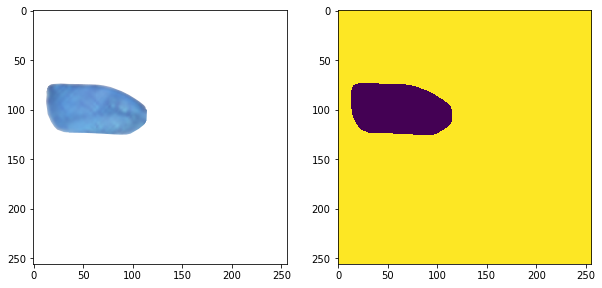

In [171]:
plt.rcParams['figure.figsize'] = [10, 20]
fig_ims, ims_axes = plt.subplots(1,2)
ims_axes[0].imshow(im)
ims_axes[1].imshow(im_binary)

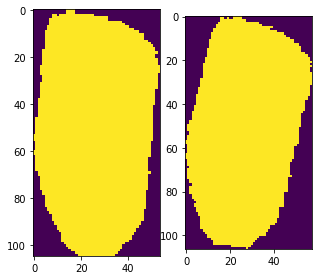

In [172]:
plt.rcParams['figure.figsize'] = [5, 5]
fig_ims, ims_axes = plt.subplots(1,2)
ims_axes[0].imshow(im_pca_binary)
ims_axes[1].imshow(im_pca_binary_rotated)

In [173]:
import pandas as pd

In [174]:
moth_geometry_df = pd.DataFrame({'img_file':png_files, 'aspect_ratio':aspect_ratios, 'nd2ndMoA_root_on_left': nd_second_moment_of_areas_root_on_left, 'nd2ndMoA_root_on_right': nd_second_moment_of_areas_root_on_right})

In [175]:
moth_geometry_df

,img_file,aspect_ratio,nd2ndMoA_root_on_left,nd2ndMoA_root_on_right
0,Crambidae_Crambinae_Crambus_pascuella_15852682...,7.194009,0.525446,0.586426
1,Crambidae_Glaphyriinae_Chalcoela_pegasalis_188...,6.309965,0.522806,0.580101
2,Crambidae_Pyraustinae_Pyrausta_acrionalis_1899...,6.598980,0.518312,0.586353
3,Drepanidae_Cyclidinae_Abraxas_submartiaria_A52...,5.714923,0.548514,0.547411
4,Drepanidae_Drepaninae_Drepana_falcataria_30036...,6.192493,0.530781,0.553790
5,Drepanidae_Thyatirinae_Parapsestis_tomponis_to...,5.817553,0.520928,0.580993
6,Erebidae_Erebinae_Erebus_albicincta_obscurata_...,5.846637,0.549131,0.538429
7,Erebidae_Herminiinae_Herminia_grisealis_A41-20...,5.880155,0.518192,0.586535
8,Erebidae_Herminiinae_Hipoepa_fractalis_V34-201...,5.236817,0.529786,0.574935
9,Gelechiidae_Dichomeridinae_Dichomeris_agonia_1...,7.728897,0.537062,0.578992


In [176]:
moth_geometry_df.to_csv('moth_geometry_atap20_rec512d.csv', sep='\t', index=False)
# moth_geometry_df.to_csv('moth_geometry_atap20_rec40d.csv', sep='\t', index=False)
# moth_geometry_df.to_csv('moth_geometry_atap20_real.csv', sep='\t', index=False)
# moth_geometry_df = pd.read_csv('moth_geometry.csv', sep='\t')

In [177]:
real = pd.read_csv('moth_geometry_atap20_real.csv', sep='\t')
rec40d = pd.read_csv('moth_geometry_atap20_rec40d.csv', sep='\t')
rec512d = pd.read_csv('moth_geometry_atap20_rec512d.csv', sep='\t')

In [178]:
cols = ['aspect_ratio', 'nd2ndMoA_root_on_left', 'nd2ndMoA_root_on_right']

aspect_ratio 0.9887794321218857 1.3568504214141637e-49
nd2ndMoA_root_on_left 0.8418206069856143 3.6118207887839635e-17
nd2ndMoA_root_on_right 0.8285088797679292 3.0947927228045694e-16


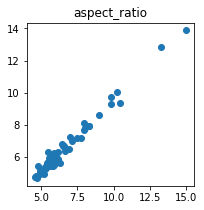

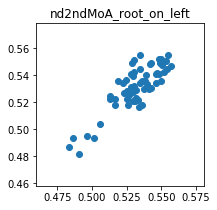

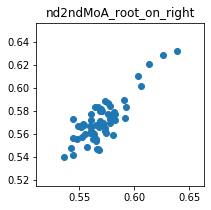

In [186]:
import scipy
from sklearn.preprocessing import MinMaxScaler
var1 = real
var2 = rec40d
for col in cols:
    plt.figure(figsize=(3,3))
    plt.title(col)
    plt.scatter(var1[col], var2[col])
#     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(var1[col], var2[col])
    pearson_r, p = scipy.stats.pearsonr(var1[col], var2[col])
    print(col, pearson_r, p)

In [14]:
fam_meta = pd.read_csv('fam_in_2019_gbif_WUver2_20220513.csv', sep=',')
fam_meta['fam_png'] = fam_meta['family'] + '.png'

In [15]:
tip_net_div_rate = pd.read_csv('TipNetDivRate.csv', sep=',')

In [16]:
tip_net_div_rate['fam_png'] = tip_net_div_rate['Family'] + '.png'

In [17]:
moth_geometry_with_meta_df = fam_meta.merge(moth_geometry_df, left_on='fam_png', right_on='img_file')
moth_geometry_with_meta_df = moth_geometry_with_meta_df.merge(tip_net_div_rate)

In [18]:
moth_geometry_with_meta_df

,sn,family,Goldstein2017,sp_count_on_gbif,out_group,no_sp_id,family_sp_count_with_photo,6groups,10groups,fam_mean_PC1,fam_mean_PC2,fam_mean_PC3,fam_png,img_file,aspect_ratio,nd2ndMoA_root_on_left,nd2ndMoA_root_on_right,Family,Rate
0,13,Eriocraniidae,30.0,34,0,0,5.0,0.0,0.0,-1.714353,0.783723,0.515385,Eriocraniidae.png,Eriocraniidae.png,8.387830,0.516030,0.590435,Eriocraniidae,2.329404
1,17,Hepialidae,652.0,692,0,0,25.0,2.0,4.0,0.849195,-0.778374,0.085901,Hepialidae.png,Hepialidae.png,5.376583,0.544265,0.572332,Hepialidae,2.581584
2,19,Nepticulidae,852.0,1054,0,0,5.0,0.0,1.0,-1.530336,0.401752,0.968383,Nepticulidae.png,Nepticulidae.png,10.691109,0.524176,0.587942,Nepticulidae,2.681620
3,21,Adelidae,294.0,407,0,0,22.0,1.0,3.0,-0.706935,-0.396246,0.311439,Adelidae.png,Adelidae.png,6.640551,0.521780,0.570753,Adelidae,2.642721
4,22,Prodoxidae,97.0,105,0,0,10.0,0.0,0.0,-1.409224,0.405129,-0.369809,Prodoxidae.png,Prodoxidae.png,7.404465,0.525689,0.589832,Prodoxidae,2.638125
5,26,Psychidae,1246.0,1424,0,0,10.0,3.0,5.0,1.014906,-0.394972,-0.638311,Psychidae.png,Psychidae.png,4.988323,0.535739,0.563594,Psychidae,4.571108
6,28,Tineidae,2110.0,2651,0,0,79.0,1.0,1.0,-1.374466,-0.037493,-0.073807,Tineidae.png,Tineidae.png,7.667257,0.520795,0.595566,Tineidae,5.080584
7,29,Roeslerstammiidae,53.0,52,0,0,3.0,1.0,3.0,-0.586655,-1.613519,0.891993,Roeslerstammiidae.png,Roeslerstammiidae.png,7.992026,0.548855,0.568091,Roeslerstammiidae,5.925015
8,30,Plutellidae,150.0,344,0,0,3.0,1.0,2.0,-0.846020,-0.609642,0.098949,Plutellidae.png,Plutellidae.png,8.217317,0.525614,0.583652,Plutellidae,6.201765
9,31,Yponomeutidae,362.0,526,0,0,25.0,0.0,0.0,-1.441188,0.133572,0.125166,Yponomeutidae.png,Yponomeutidae.png,7.189542,0.528967,0.588509,Yponomeutidae,6.233291


In [19]:
color_map = np.array(['#E1DFCD', '#7ABDC7', '#987EA7', '#849E73', '#E7C734', '#FD8889'])

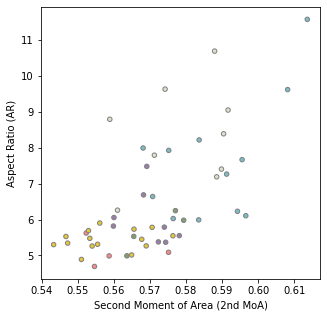

In [20]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.ylabel('Aspect Ratio (AR)')
plt.xlabel('Second Moment of Area (2nd MoA)')
plt.scatter(moth_geometry_with_meta_df.nd2ndMoA_root_on_right, moth_geometry_with_meta_df.aspect_ratio, c=color_map[moth_geometry_with_meta_df['6groups'].astype(int)], alpha=1, linewidth=1, s=20, edgecolor='gray')
plt.savefig('family_mean_wing_geometry.jpg', dpi=300)

In [21]:
moth_geometry_with_meta_df['Goldstein2017'] = moth_geometry_with_meta_df['Goldstein2017'].astype(int)
moth_geometry_with_meta_df['family_sp_count_with_photo'] = moth_geometry_with_meta_df.family_sp_count_with_photo.astype(int)
moth_geometry_with_meta_df['6groups'] = moth_geometry_with_meta_df['6groups'].astype(int)
moth_geometry_with_meta_df['10groups'] = moth_geometry_with_meta_df['10groups'].astype(int)
#moth_geometry_with_meta_df

In [22]:
# moth_geometry_with_meta_df.to_csv(f'moth_geometry_with_meta.csv', sep='\t', index=False)

In [23]:
topNfams = moth_geometry_with_meta_df.sort_values('Goldstein2017').iloc[-20:].family.values
topNfams

array(['Riodinidae', 'Limacodidae', 'Nolidae', 'Cosmopterigidae',
       'Gracillariidae', 'Lasiocampidae', 'Tineidae', 'Depressariidae',
       'Saturniidae', 'Notodontidae', 'Hesperiidae', 'Gelechiidae',
       'Lycaenidae', 'Pyralidae', 'Nymphalidae', 'Crambidae',
       'Tortricidae', 'Noctuidae', 'Geometridae', 'Erebidae'],
      dtype=object)

In [24]:
moth_geometry_with_meta_df

,sn,family,Goldstein2017,sp_count_on_gbif,out_group,no_sp_id,family_sp_count_with_photo,6groups,10groups,fam_mean_PC1,fam_mean_PC2,fam_mean_PC3,fam_png,img_file,aspect_ratio,nd2ndMoA_root_on_left,nd2ndMoA_root_on_right,Family,Rate
0,13,Eriocraniidae,30,34,0,0,5,0,0,-1.714353,0.783723,0.515385,Eriocraniidae.png,Eriocraniidae.png,8.387830,0.516030,0.590435,Eriocraniidae,2.329404
1,17,Hepialidae,652,692,0,0,25,2,4,0.849195,-0.778374,0.085901,Hepialidae.png,Hepialidae.png,5.376583,0.544265,0.572332,Hepialidae,2.581584
2,19,Nepticulidae,852,1054,0,0,5,0,1,-1.530336,0.401752,0.968383,Nepticulidae.png,Nepticulidae.png,10.691109,0.524176,0.587942,Nepticulidae,2.681620
3,21,Adelidae,294,407,0,0,22,1,3,-0.706935,-0.396246,0.311439,Adelidae.png,Adelidae.png,6.640551,0.521780,0.570753,Adelidae,2.642721
4,22,Prodoxidae,97,105,0,0,10,0,0,-1.409224,0.405129,-0.369809,Prodoxidae.png,Prodoxidae.png,7.404465,0.525689,0.589832,Prodoxidae,2.638125
5,26,Psychidae,1246,1424,0,0,10,3,5,1.014906,-0.394972,-0.638311,Psychidae.png,Psychidae.png,4.988323,0.535739,0.563594,Psychidae,4.571108
6,28,Tineidae,2110,2651,0,0,79,1,1,-1.374466,-0.037493,-0.073807,Tineidae.png,Tineidae.png,7.667257,0.520795,0.595566,Tineidae,5.080584
7,29,Roeslerstammiidae,53,52,0,0,3,1,3,-0.586655,-1.613519,0.891993,Roeslerstammiidae.png,Roeslerstammiidae.png,7.992026,0.548855,0.568091,Roeslerstammiidae,5.925015
8,30,Plutellidae,150,344,0,0,3,1,2,-0.846020,-0.609642,0.098949,Plutellidae.png,Plutellidae.png,8.217317,0.525614,0.583652,Plutellidae,6.201765
9,31,Yponomeutidae,362,526,0,0,25,0,0,-1.441188,0.133572,0.125166,Yponomeutidae.png,Yponomeutidae.png,7.189542,0.528967,0.588509,Yponomeutidae,6.233291


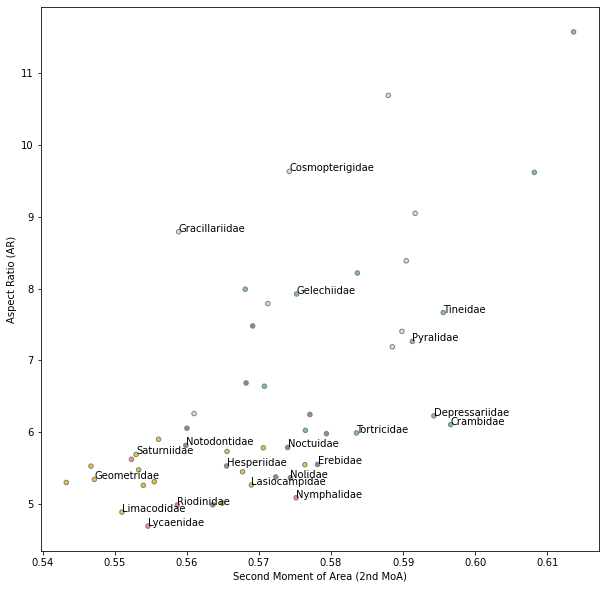

In [27]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

plt.rcParams['figure.figsize'] = [10, 10]
plt.ylabel('Aspect Ratio (AR)')
plt.xlabel('Second Moment of Area (2nd MoA)')
plt.scatter(moth_geometry_with_meta_df.nd2ndMoA_root_on_right, moth_geometry_with_meta_df.aspect_ratio, c=color_map[moth_geometry_with_meta_df['6groups'].astype(int)], alpha=1, linewidth=1, s=20, edgecolor='gray')

for topNfam in topNfams:
    x_, y_ = moth_geometry_with_meta_df[moth_geometry_with_meta_df.family == topNfam][['nd2ndMoA_root_on_right', 'aspect_ratio']].values[0]
    plt.text(x_, y_, topNfam)

#plt.savefig('family_mean_wing_geometry.jpg', dpi=300)
plt.savefig('family_mean_wing_geometry.pdf', dpi=300)

In [66]:
import plotly.graph_objects as go
import numpy as np

#X_dr[:,0], X_dr[:,1], X_dr[:,2], color=cls_colors,
fig = go.Figure(data=[go.Scatter3d(
    x=moth_geometry_with_meta_df.nd2ndMoA_root_on_right,
    y=moth_geometry_with_meta_df.aspect_ratio,
    z=moth_geometry_with_meta_df.Rate,
    mode='markers',
    marker=dict(
        size=5,
        color=color_map[moth_geometry_with_meta_df['6groups'].astype(int)],
        opacity=1,
        line=dict(
            color='black',
            width=1
        )
    ),
    layout = go.Layout(
        showlegend=True,
        # scene=go.Scene(
        #     xaxis=go.XAxis(title='Second Moment of Area (2nd MoA)'),
        #     yaxis=go.YAxis(title='Aspect Ratio (AR)'),
        #     zaxis=go.ZAxis(title='Net Div Rate')
        # )
    ),
    text=moth_geometry_with_meta_df.Family
)
# ), go.Scatter3d(
#     x=group_X_dr[:,0],
#     y=group_X_dr[:,1],
#     z=group_X_dr[:,2],
#     mode='text',
#     text=txts,
# )
])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.write_html(f'family_mean_wing_geometry3d.html')
#fig.show(renderer="iframe")

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter3d: 'layout'

Did you mean "line"?

    Valid properties:
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        error_x
            :class:`plotly.graph_objects.scatter3d.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter3d.ErrorY` instance
            or dict with compatible properties
        error_z
            :class:`plotly.graph_objects.scatter3d.ErrorZ` instance
            or dict with compatible properties
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.scatter3d.Hoverlabel`
            instance or dict with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Sets text elements associated with each (x,y,z)
            triplet. If a single string, the same string appears
            over all the data points. If an array of string, the
            items are mapped in order to the this trace's (x,y,z)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter3d.Legendgrouptitle
            ` instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        line
            :class:`plotly.graph_objects.scatter3d.Line` instance
            or dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter3d.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        projection
            :class:`plotly.graph_objects.scatter3d.Projection`
            instance or dict with compatible properties
        scene
            Sets a reference between this trace's 3D coordinate
            system and a 3D scene. If "scene" (the default value),
            the (x,y,z) coordinates refer to `layout.scene`. If
            "scene2", the (x,y,z) coordinates refer to
            `layout.scene2`, and so on.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stream
            :class:`plotly.graph_objects.scatter3d.Stream` instance
            or dict with compatible properties
        surfaceaxis
            If "-1", the scatter points are not fill with a surface
            If 0, 1, 2, the scatter points are filled with a
            Delaunay surface about the x, y, z respectively.
        surfacecolor
            Sets the surface fill color.
        text
            Sets text elements associated with each (x,y,z)
            triplet. If a single string, the same string appears
            over all the data points. If an array of string, the
            items are mapped in order to the this trace's (x,y,z)
            coordinates. If trace `hoverinfo` contains a "text"
            flag and "hovertext" is not set, these elements will be
            seen in the hover labels.
        textfont
            :class:`plotly.graph_objects.scatter3d.Textfont`
            instance or dict with compatible properties
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            `textposition`.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `texttemplate`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the y coordinates.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        z
            Sets the z coordinates.
        zcalendar
            Sets the calendar system to use with `z` date data.
        zhoverformat
            Sets the hover text formatting rulefor `z`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `zaxis.hoverformat`.
        zsrc
            Sets the source reference on Chart Studio Cloud for
            `z`.
        
Did you mean "line"?

Bad property path:
layout
^^^^^^